## ecom.tech ноутбук к соревнованию по NLP-задачи мульти-лейбл классификации отзывов о доставке. Часть 1 - Дообучение модели и получение весов

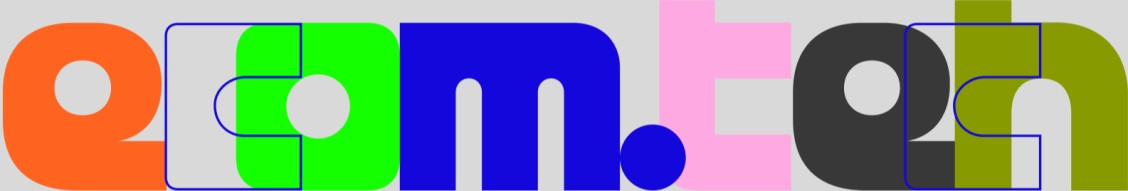

**Важно!**

Обязательно изменить пути к тренировочным данным и файлу с описанием классов - пункт ноутбука `Обработка данных`. Далее обязательно изменить путь сохранения весов модели, особенно критически это касается `best`-версии - именно она будет использоваться для составления прогнозов.

Не стоит сразу же нажимать на `Выполнить всё`. Советую выполнять ячейки поэтапно, попутно читая всю информацию. Спасибо.

# Импорт библиотек

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import warnings
import os
import random

from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
warnings.filterwarnings('ignore')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_name = 'ai-forever/ruRoberta-large'

In [ ]:
def set_seed(seed):
    '''Зафиксируем случайности'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(RANDOM_STATE)

Random seed set as 42


# Подготовка данных

**Памятка**: просьба сменить пути к файлам описания классов (`trends_description.csv`) и файл с тренировочными данными (`train.csv`), иначе случится ошибка.

In [ ]:
descrs = pd.read_csv('/kaggle/input/ecom-tech-dataset-text-multi-label-classification/trends_description.csv.csv')

In [ ]:
train_df = pd.read_csv(
    '/kaggle/input/ecom-tech-dataset-text-multi-label-classification/train.csv.csv'
    ).drop(['assessment', 'Unnamed: 0', 'index', 'tags'], axis=1)

In [ ]:
train_df[[f'trend_id_res{i}' for i in range(50)]] = train_df[[f'trend_id_res{i}' for i in range(50)]].astype(bool)
train_df['text'] = train_df['text'].astype(str)

In [ ]:
train_df.head()

,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,trend_id_res5,trend_id_res6,trend_id_res7,trend_id_res8,...,trend_id_res40,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49
0,"Маленький выбор товаров, хотелось бы ассортиме...",False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,Быстро,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Доставка постоянно задерживается,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Наценка и ассортимент расстраивают,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,Можно немного скинуть минимальную сумму заказа...,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


Разделим наши данные на обучающую и тестовую части.

In [ ]:
train_data, val_data = train_test_split(
    train_df,
    random_state=RANDOM_STATE,
    test_size=0.2
    )

# ruRoBERTa - дообучение

Эксприментальным путём мы выявили модель, показывающую себя на пока что лучше остальных - это `ai-forever/ruRoberta-large`. Объявим токенизатор и создаим эмбеддинги из наших текстов.

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification


tokenizer = RobertaTokenizer.from_pretrained(model_name)

vocab.json:   0%|          | 0.00/1.81M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/674 [00:00<?, ?B/s]

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.text = list(df['text'])
        self.max_len = max_len
        self.targets = self.df[target_list].values

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        item = {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'text': text,
            'targets': torch.FloatTensor(self.targets[index])
        }

        return item

In [ ]:
MAX_LEN = 128
BATCH_SIZE = 32
targets = [f'trend_id_res{i}' for i in range(50)]

train_dataset = CustomDataset(train_data, tokenizer, MAX_LEN, targets)
val_dataset = CustomDataset(val_data, tokenizer, MAX_LEN, targets)

In [ ]:
train_data_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)


val_data_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

Взгляним, как выглядят наши данные из датасета.

In [ ]:
next(iter(train_dataset))

{'input_ids': tensor([    1,  5560,    16,   451,  3362,    50, 25602,    65,   283,    18,
           289,  3362,    50, 25602,    65,  1003,    18,   664,  2007,  1528,
           332,  3634,  4777,  4789,  1011, 36142,    16,  3009,  7219,     2,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

Объявим наш класс для BERT и объявим выбранную модель.

In [ ]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()

        self.bert_model = RobertaForSequenceClassification.from_pretrained(
            model_name,
            return_dict=True,
            problem_type='multi_label_classification',
            num_labels=50
        )

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )

        return output.logits

model = BERTClass().to(device)

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Зададим функцию потерь - Бинарную кросс-энтропию и оптимизатор - Адам. В ходе наблюдений выявлен оптимальный размер градиентного шага - 1e-5.

In [ ]:
def loss_fn(outputs, targets):
    '''Бинарная кросс-энтропия'''
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
from transformers import AdamW

EPOCHS = 45
optimizer = AdamW(model.parameters(), lr = 1e-5)

Далее с помощью двух функций в ходе 45 эпох дообучим и составим валидацию модели.

In [ ]:
def ecom_format(y):
    '''Перевод y в формат соревнования ecom.tech'''
    y = [' '.join(np.where(y[i] == 1)[0].astype(str).tolist()) for i in range(y.shape[0])]
    return np.array(y)

def train_model(training_loader, model, optimizer):
    '''Дообучение модели'''
    losses = []
    correct_predictions = 0
    num_samples = 0

    model.train()

    loop = tq.tqdm(
        enumerate(training_loader),
        total=len(training_loader),
        leave=True,
        colour='steelblue'
    )

    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        # forward
        outputs = model(ids, mask, token_type_ids)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())

        outputs = torch.sigmoid(outputs).cpu().detach().numpy()
        outputs = (outputs >= 0.45).astype(float)

        targets = targets.cpu().detach().numpy()

        outputs = ecom_format(outputs)
        targets = ecom_format(targets)

        correct_predictions += np.sum(outputs==targets)
        num_samples += targets.size

        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    # returning: trained model, model accuracy, mean loss
    return model, float(correct_predictions)/num_samples, np.mean(losses)

In [ ]:
def eval_model(validation_loader, model, optimizer):
    '''Валидация модели'''
    losses = []
    correct_predictions = 0
    num_samples = 0

    model.eval()

    with torch.no_grad():

        for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)

            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # validation accuracy
            outputs = torch.sigmoid(outputs).cpu().detach().numpy()
            outputs = (outputs >= 0.45).astype(float)
            targets = targets.cpu().detach().numpy()

            outputs = ecom_format(outputs)
            targets = ecom_format(targets)
            correct_predictions += np.sum(outputs==targets)
            num_samples += targets.size

    return float(correct_predictions)/num_samples, np.mean(losses)

Для лучшей наглядности обучения и контроля за временем импортируем библиотеку tqdm. Следующий код запускает дообучение модели.

**Важно:** нужно задать имя для сохранения весов модели. Их потом стоит использовать в ходе составления прогнозов.

In [ ]:
from collections import defaultdict
import tqdm.notebook as tq


history = defaultdict(list)
best_accuracy = 0

for epoch in range(1, EPOCHS + 1):
    print(f'Epoch {epoch}/{EPOCHS}')

    model, train_acc, train_loss = train_model(
        train_data_loader,
        model,
        optimizer
        )

    val_acc, val_loss = eval_model(
        val_data_loader,
        model,
        optimizer
        )

    print(f'train_loss={train_loss:.4f}, \
            val_loss={val_loss:.4f}, \
            train_acc={train_acc:.4f}, \
            val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # save the best model
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), "ruroberta-ecom-tech-best.pth")
        best_accuracy = val_acc

Epoch 1/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.2850,             val_loss=0.1532,             train_acc=0.0005,             val_acc=0.0000
Epoch 2/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.1508,             val_loss=0.1209,             train_acc=0.0000,             val_acc=0.0000
Epoch 3/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.1225,             val_loss=0.1103,             train_acc=0.0000,             val_acc=0.0000
Epoch 4/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.1119,             val_loss=0.0977,             train_acc=0.0035,             val_acc=0.0335
Epoch 5/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0989,             val_loss=0.0860,             train_acc=0.0841,             val_acc=0.2119
Epoch 6/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0881,             val_loss=0.0769,             train_acc=0.1904,             val_acc=0.3038
Epoch 7/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0788,             val_loss=0.0707,             train_acc=0.2885,             val_acc=0.3459
Epoch 8/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0707,             val_loss=0.0638,             train_acc=0.3656,             val_acc=0.4357
Epoch 9/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0640,             val_loss=0.0603,             train_acc=0.4365,             val_acc=0.4530
Epoch 10/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0577,             val_loss=0.0576,             train_acc=0.4895,             val_acc=0.4843
Epoch 11/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0526,             val_loss=0.0550,             train_acc=0.5281,             val_acc=0.4832
Epoch 12/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0478,             val_loss=0.0527,             train_acc=0.5654,             val_acc=0.4941
Epoch 13/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0437,             val_loss=0.0513,             train_acc=0.6038,             val_acc=0.5286
Epoch 14/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0400,             val_loss=0.0504,             train_acc=0.6422,             val_acc=0.5330
Epoch 15/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0370,             val_loss=0.0495,             train_acc=0.6693,             val_acc=0.5373
Epoch 16/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0336,             val_loss=0.0483,             train_acc=0.7071,             val_acc=0.5405
Epoch 17/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0312,             val_loss=0.0478,             train_acc=0.7266,             val_acc=0.5351
Epoch 18/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0290,             val_loss=0.0477,             train_acc=0.7485,             val_acc=0.5416
Epoch 19/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0268,             val_loss=0.0462,             train_acc=0.7726,             val_acc=0.5524
Epoch 20/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0248,             val_loss=0.0450,             train_acc=0.7904,             val_acc=0.5503
Epoch 21/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0227,             val_loss=0.0456,             train_acc=0.8186,             val_acc=0.5524
Epoch 22/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0211,             val_loss=0.0463,             train_acc=0.8405,             val_acc=0.5535
Epoch 23/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0195,             val_loss=0.0452,             train_acc=0.8515,             val_acc=0.5730
Epoch 24/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0182,             val_loss=0.0452,             train_acc=0.8726,             val_acc=0.5600
Epoch 25/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0172,             val_loss=0.0459,             train_acc=0.8786,             val_acc=0.5557
Epoch 26/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0164,             val_loss=0.0449,             train_acc=0.8837,             val_acc=0.5795
Epoch 27/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0152,             val_loss=0.0452,             train_acc=0.8953,             val_acc=0.5578
Epoch 28/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0140,             val_loss=0.0447,             train_acc=0.9127,             val_acc=0.5719
Epoch 29/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0131,             val_loss=0.0462,             train_acc=0.9183,             val_acc=0.5784
Epoch 30/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0124,             val_loss=0.0454,             train_acc=0.9273,             val_acc=0.5665
Epoch 31/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0118,             val_loss=0.0461,             train_acc=0.9289,             val_acc=0.5654
Epoch 32/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0111,             val_loss=0.0443,             train_acc=0.9365,             val_acc=0.5849
Epoch 33/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0104,             val_loss=0.0454,             train_acc=0.9456,             val_acc=0.5741
Epoch 34/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0098,             val_loss=0.0455,             train_acc=0.9502,             val_acc=0.5838
Epoch 35/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0094,             val_loss=0.0465,             train_acc=0.9511,             val_acc=0.5686
Epoch 36/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0088,             val_loss=0.0451,             train_acc=0.9543,             val_acc=0.5805
Epoch 37/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0084,             val_loss=0.0457,             train_acc=0.9600,             val_acc=0.5816
Epoch 38/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0078,             val_loss=0.0462,             train_acc=0.9676,             val_acc=0.5773
Epoch 39/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0076,             val_loss=0.0466,             train_acc=0.9630,             val_acc=0.5676
Epoch 40/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0076,             val_loss=0.0463,             train_acc=0.9630,             val_acc=0.5751
Epoch 41/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0070,             val_loss=0.0461,             train_acc=0.9667,             val_acc=0.5957
Epoch 42/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0067,             val_loss=0.0470,             train_acc=0.9681,             val_acc=0.5859
Epoch 43/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0064,             val_loss=0.0486,             train_acc=0.9700,             val_acc=0.5751
Epoch 44/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0061,             val_loss=0.0480,             train_acc=0.9738,             val_acc=0.5935
Epoch 45/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0058,             val_loss=0.0488,             train_acc=0.9765,             val_acc=0.5935


# Валидация модели

Ещё раз проведём валидацию модели и посмотрим, где модель больше всего ошибается, на каких классах.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
def get_predictions(model, data_loader):
    '''Получение предсказаний на валидационных данных'''
    model = model.eval()

    texts = []
    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
      for data in data_loader:
        text = data["text"]
        ids = data["input_ids"].to(device, dtype = torch.long)
        mask = data["attention_mask"].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data["targets"].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)
        outputs = torch.sigmoid(outputs).detach().cpu()

        preds = outputs.round()
        targets = targets.detach().cpu()

        texts.extend(text)
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        target_values.extend(targets)

    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    target_values = torch.stack(target_values)

    return texts, predictions, prediction_probs, target_values

In [ ]:
texts, predictions, prediction_probs, target_values = get_predictions(model, val_data_loader)

In [ ]:
print(classification_report(target_values, predictions, target_names=targets))

                precision    recall  f1-score   support

 trend_id_res0       0.84      0.77      0.81       176
 trend_id_res1       0.79      0.88      0.83        77
 trend_id_res2       0.78      0.68      0.72       111
 trend_id_res3       0.62      0.83      0.71        72
 trend_id_res4       0.45      0.56      0.50        18
 trend_id_res5       0.78      0.88      0.82         8
 trend_id_res6       1.00      0.60      0.75         5
 trend_id_res7       0.75      0.75      0.75         8
 trend_id_res8       0.78      0.81      0.79        31
 trend_id_res9       0.00      0.00      0.00         1
trend_id_res10       0.54      0.70      0.61        20
trend_id_res11       0.86      0.86      0.86        21
trend_id_res12       0.92      0.96      0.94       133
trend_id_res13       0.50      0.40      0.44         5
trend_id_res14       0.47      0.64      0.54        11
trend_id_res15       0.71      0.67      0.69        15
trend_id_res16       0.76      0.64      0.70  

# График ecom.tech accuracy

Посмотрим, как на тренировочных и валидационных данных менялся размер метрики, составленной в ходе соревнования.

In [ ]:
import matplotlib.pyplot as plt

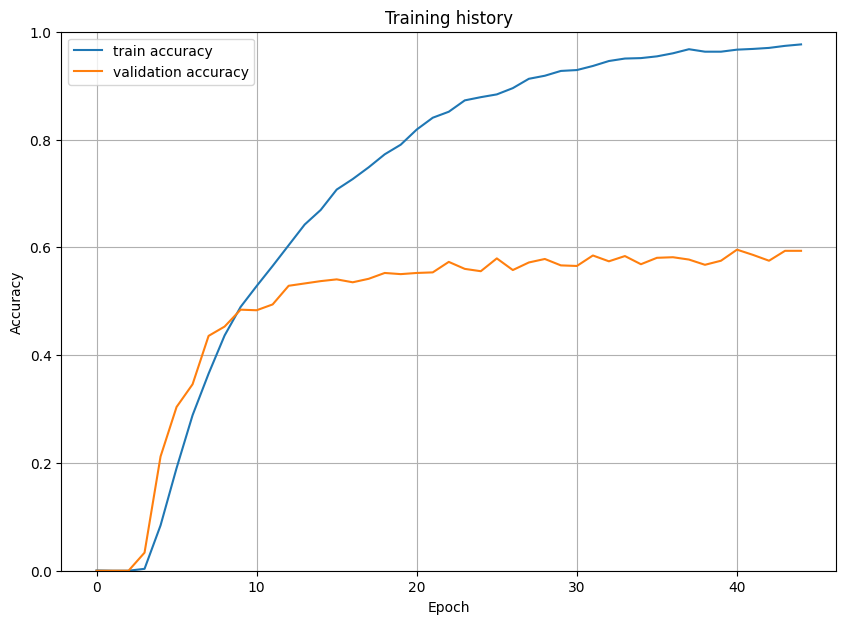

In [ ]:
plt.rcParams["figure.figsize"] = (10,7)

plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend()
plt.ylim([0, 1]);
plt.grid()
plt.show()

# Итого

Чтобы не загружать один ноутбук и дообучением, и прогнозами, было принято решение разделить ноутбук на две части. Ноутбук `Samoilov Vadim ecom.tech NLP Prediction` использовавлся для выполнения предсказаний, которые затем заливались на воркшоп. Просьба пройти в данный ноутбук и быть готовым загрузить туда полученную модель - по дефолту она имеет название `ruroberta-ecom-tech-best.pth`.

Благодарю за уделённое время моей работе! Увидимся во второй части - `Samoilov Vadim ecom.tech NLP Prediction`!


# Прочие эксперименты (после финала соревнования)

## Работа с размеченными данными

Попробуем использовать всю информацию из нашего датасета, а именно используем помимо текста ещё `tags` и `assessment`.

In [ ]:
train_df = pd.read_csv(
    '/kaggle/input/ecom-tech-dataset-text-multi-label-classification/train.csv.csv'
    ).drop(['Unnamed: 0', 'index'], axis=1)

In [ ]:
train_df[[f'trend_id_res{i}' for i in range(50)]] = train_df[[f'trend_id_res{i}' for i in range(50)]].astype(bool)
train_df['text'] = train_df['text'].astype(str)
train_df['tags'] = train_df['tags'].fillna('').str.strip('{}').str.split(',')

In [ ]:
train_df.head()

,assessment,tags,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,trend_id_res5,trend_id_res6,...,trend_id_res40,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49
0,6.0,"[ASSORTMENT, PROMOTIONS, DELIVERY]","Маленький выбор товаров, хотелось бы ассортиме...",False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,4.0,"[ASSORTMENT, PRICE, PRODUCTS_QUALITY, DELIVERY]",Быстро,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,6.0,"[DELIVERY, PROMOTIONS, PRICE, ASSORTMENT, SUPP...",Доставка постоянно задерживается,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,6.0,"[PRICE, PROMOTIONS, ASSORTMENT]",Наценка и ассортимент расстраивают,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,6.0,"[PRICE, PROMOTIONS]",Можно немного скинуть минимальную сумму заказа...,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Далее тэги и оценку вставим прямо в сам текст.

In [ ]:
def transform_text(row):
    string = f'''Отзыв: {row['text']}, тэги: {', '.join(row['tags'])}, оценка: {row['assessment']}'''
    return string

train_df['text'] = train_df.apply(transform_text, axis=1)

In [ ]:
train_df.iloc[0].text

'Отзыв: Маленький выбор товаров, хотелось бы ассортимент больше, а так вроде бы все хорошо, тэги: ASSORTMENT, PROMOTIONS, DELIVERY, оценка: 6.0'

Будем далее работать с такими данными, то есть наш текст содержит отзыв пользователя, поставленные им тэги и оценка.

In [ ]:
train_df = train_df.drop(['assessment', 'tags'], axis=1)

In [ ]:
train_data, val_data = train_test_split(
    train_df,
    random_state=RANDOM_STATE,
    test_size=0.2
    )

In [ ]:
train_dataset = CustomDataset(train_data, tokenizer, MAX_LEN, targets)
val_dataset = CustomDataset(val_data, tokenizer, MAX_LEN, targets)

In [ ]:
train_data_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)


val_data_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [ ]:
next(iter(train_dataset))

{'input_ids': tensor([    1,  3131,   317,   471,    30,  1506,    16,   451,  3362,    50,
         25602,    65,   283,    18,   289,  3362,    50, 25602,    65,  1003,
            18,   664,  2007,  1528,   332,  3634,  4777,  4789,  1011, 36142,
            16,  3009,  7219,    16,   305,   552,  1181,    30, 50062,    55,
            51, 44189,    49,    41, 23540,    16,  2378,    54,    45,    39,
            41,    16,  3271,    41,    48, 19233, 17881,    61,    16, 25318,
            30,  1383,    18,    20,     2,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

Ещё раз объявим прежнюю модель и дообучим модель ruRobera-large.

In [ ]:
EPOCHS = 45

model = BERTClass().to(device)
optimizer = AdamW(model.parameters(), lr = 1e-5)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from collections import defaultdict
import tqdm.notebook as tq

history = defaultdict(list)
best_accuracy = 0

for epoch in range(1, EPOCHS + 1):
    print(f'Epoch {epoch}/{EPOCHS}')

    model, train_acc, train_loss = train_model(
        train_data_loader,
        model,
        optimizer
        )

    val_acc, val_loss = eval_model(
        val_data_loader,
        model,
        optimizer
        )

    print(f'train_loss={train_loss:.4f}, \
            val_loss={val_loss:.4f}, \
            train_acc={train_acc:.4f}, \
            val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # save the best model
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), "ruroberta-allfeatures-best.pth")
        best_accuracy = val_acc

Epoch 1/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.2671,             val_loss=0.1490,             train_acc=0.0008,             val_acc=0.0000
Epoch 2/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.1395,             val_loss=0.1188,             train_acc=0.0000,             val_acc=0.0000
Epoch 3/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.1177,             val_loss=0.1016,             train_acc=0.0057,             val_acc=0.0119
Epoch 4/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.1019,             val_loss=0.0879,             train_acc=0.0830,             val_acc=0.1935
Epoch 5/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0896,             val_loss=0.0779,             train_acc=0.1950,             val_acc=0.2411
Epoch 6/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0792,             val_loss=0.0692,             train_acc=0.2926,             val_acc=0.3838
Epoch 7/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0707,             val_loss=0.0653,             train_acc=0.3767,             val_acc=0.4281
Epoch 8/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0635,             val_loss=0.0598,             train_acc=0.4521,             val_acc=0.4703
Epoch 9/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0575,             val_loss=0.0575,             train_acc=0.5043,             val_acc=0.5016
Epoch 10/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0520,             val_loss=0.0549,             train_acc=0.5530,             val_acc=0.5189
Epoch 11/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0474,             val_loss=0.0527,             train_acc=0.5876,             val_acc=0.5222
Epoch 12/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0434,             val_loss=0.0523,             train_acc=0.6260,             val_acc=0.5222
Epoch 13/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0402,             val_loss=0.0491,             train_acc=0.6501,             val_acc=0.5330
Epoch 14/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0364,             val_loss=0.0495,             train_acc=0.6898,             val_acc=0.5373
Epoch 15/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0335,             val_loss=0.0488,             train_acc=0.7090,             val_acc=0.5449
Epoch 16/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0308,             val_loss=0.0472,             train_acc=0.7385,             val_acc=0.5470
Epoch 17/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0285,             val_loss=0.0470,             train_acc=0.7626,             val_acc=0.5578
Epoch 18/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0265,             val_loss=0.0458,             train_acc=0.7788,             val_acc=0.5654
Epoch 19/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0243,             val_loss=0.0452,             train_acc=0.8058,             val_acc=0.5686
Epoch 20/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0226,             val_loss=0.0446,             train_acc=0.8237,             val_acc=0.5751
Epoch 21/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0209,             val_loss=0.0439,             train_acc=0.8394,             val_acc=0.5751
Epoch 22/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0194,             val_loss=0.0448,             train_acc=0.8529,             val_acc=0.5611
Epoch 23/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0179,             val_loss=0.0441,             train_acc=0.8751,             val_acc=0.5849
Epoch 24/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0167,             val_loss=0.0437,             train_acc=0.8851,             val_acc=0.5892
Epoch 25/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0157,             val_loss=0.0445,             train_acc=0.8945,             val_acc=0.5578
Epoch 26/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0144,             val_loss=0.0436,             train_acc=0.9105,             val_acc=0.5751
Epoch 27/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0134,             val_loss=0.0445,             train_acc=0.9148,             val_acc=0.5914
Epoch 28/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0128,             val_loss=0.0442,             train_acc=0.9237,             val_acc=0.5859
Epoch 29/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0119,             val_loss=0.0441,             train_acc=0.9300,             val_acc=0.5784
Epoch 30/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0110,             val_loss=0.0450,             train_acc=0.9419,             val_acc=0.5827
Epoch 31/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0103,             val_loss=0.0440,             train_acc=0.9451,             val_acc=0.5849
Epoch 32/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0101,             val_loss=0.0461,             train_acc=0.9473,             val_acc=0.5816
Epoch 33/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0096,             val_loss=0.0454,             train_acc=0.9470,             val_acc=0.5827
Epoch 34/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0089,             val_loss=0.0437,             train_acc=0.9562,             val_acc=0.5881
Epoch 35/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0081,             val_loss=0.0454,             train_acc=0.9627,             val_acc=0.5859
Epoch 36/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0077,             val_loss=0.0468,             train_acc=0.9659,             val_acc=0.5827
Epoch 37/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0075,             val_loss=0.0459,             train_acc=0.9665,             val_acc=0.5968
Epoch 38/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0069,             val_loss=0.0456,             train_acc=0.9719,             val_acc=0.5892
Epoch 39/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0065,             val_loss=0.0453,             train_acc=0.9727,             val_acc=0.5924
Epoch 40/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0060,             val_loss=0.0461,             train_acc=0.9773,             val_acc=0.5935
Epoch 41/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0059,             val_loss=0.0459,             train_acc=0.9776,             val_acc=0.5903
Epoch 42/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0059,             val_loss=0.0464,             train_acc=0.9781,             val_acc=0.5914
Epoch 43/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0058,             val_loss=0.0477,             train_acc=0.9773,             val_acc=0.5751
Epoch 44/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0053,             val_loss=0.0479,             train_acc=0.9827,             val_acc=0.5881
Epoch 45/45


  0%|          | 0/116 [00:00<?, ?it/s]

train_loss=0.0047,             val_loss=0.0471,             train_acc=0.9876,             val_acc=0.5870


In [ ]:
texts, predictions, prediction_probs, target_values = get_predictions(model, val_data_loader)

In [ ]:
print(classification_report(target_values, predictions, target_names=targets))

                precision    recall  f1-score   support

 trend_id_res0       0.82      0.78      0.80       176
 trend_id_res1       0.81      0.84      0.83        77
 trend_id_res2       0.71      0.73      0.72       111
 trend_id_res3       0.65      0.74      0.69        72
 trend_id_res4       0.56      0.50      0.53        18
 trend_id_res5       0.80      1.00      0.89         8
 trend_id_res6       1.00      0.60      0.75         5
 trend_id_res7       0.60      0.38      0.46         8
 trend_id_res8       0.72      0.94      0.82        31
 trend_id_res9       0.00      0.00      0.00         1
trend_id_res10       0.62      0.65      0.63        20
trend_id_res11       0.79      0.90      0.84        21
trend_id_res12       0.92      0.95      0.94       133
trend_id_res13       0.50      0.20      0.29         5
trend_id_res14       0.58      0.64      0.61        11
trend_id_res15       0.77      0.67      0.71        15
trend_id_res16       0.67      0.72      0.69  

# График accuracy для обучения с полными данными

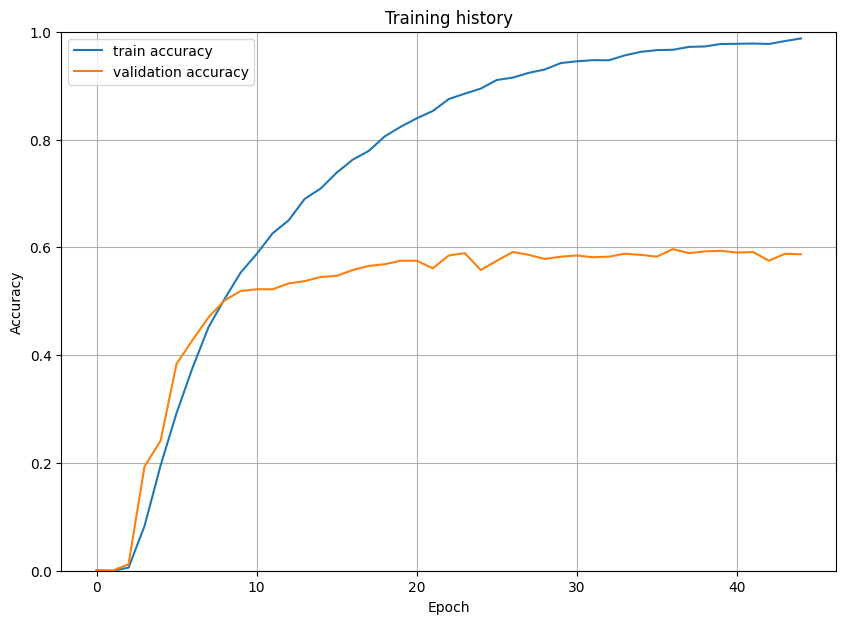

In [ ]:
plt.rcParams["figure.figsize"] = (10,7)

plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend()
plt.ylim([0, 1]);
plt.grid()
plt.show()